In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pyproj import CRS
import pathlib
from pathlib import Path
from shapely import wkt
from tqdm import tqdm

import math
import codecs

from shapely import wkt

import folium
from folium import features
from folium import plugins

import gzip
from xml.etree.ElementTree import Element, SubElement, Comment, tostring
import xml.etree.ElementTree as ET

# to read the excel 
from openpyxl import load_workbook
from openpyxl import Workbook

# import folium
from shapely.geometry import LineString, MultiLineString
import branca.colormap as cmp
from folium.plugins import Search

In [2]:
linkstats=pd.read_csv('../../sf-tscore/to_SAM/5PC-Sample-IX-Trips/10.linkstats.csv.gz',compression='gzip')
linkstats.head()

,link,from,to,hour,length,freespeed,capacity,stat,volume,traveltime
0,3640,961,1022,0.0,85.415,7.45,350.0,AVG,0.0,11.465101
1,3640,961,1022,1.0,85.415,7.45,350.0,AVG,1.0,11.465101
2,3640,961,1022,2.0,85.415,7.45,350.0,AVG,0.0,11.465101
3,3640,961,1022,3.0,85.415,7.45,350.0,AVG,0.0,11.465101
4,3640,961,1022,4.0,85.415,7.45,350.0,AVG,0.0,11.465101


In [8]:
def time_period(x):
    if x<7:
        return "EA"
    elif x<10:
        return 'AMPEAK'
    elif x<16:
        return 'MD'
    elif x<20:
        return 'PMPEAK'
    else:
        return 'EV'
    
linkstats['TIMEPERIOD']=linkstats['hour'].apply(time_period)
linkstats.head()

,link,from,to,hour,length,freespeed,capacity,stat,volume,traveltime,TIMEPERIOD
0,3640,961,1022,0.0,85.415,7.45,350.0,AVG,0.0,11.465101,EA
1,3640,961,1022,1.0,85.415,7.45,350.0,AVG,1.0,11.465101,EA
2,3640,961,1022,2.0,85.415,7.45,350.0,AVG,0.0,11.465101,EA
3,3640,961,1022,3.0,85.415,7.45,350.0,AVG,0.0,11.465101,EA
4,3640,961,1022,4.0,85.415,7.45,350.0,AVG,0.0,11.465101,EA


In [19]:
linkstats_grouped=linkstats.groupby(['link','from','to','TIMEPERIOD']).agg({'length':'max',
                                                              'freespeed':'max',
                                                              'volume':'sum',
                                                                           'capacity':'max',
                                                                           'traveltime':'max'}).reset_index()

linkstats_grouped['link']=linkstats_grouped['link'].astype(str)
linkstats_grouped['from']=linkstats_grouped['from'].astype(str)
linkstats_grouped['to']=linkstats_grouped['to'].astype(str)

In [68]:
beam_input_network=gpd.read_file('../SF_CHAMP_Converted/sfNetwork.geojsonl')

beam_input_network.head()

,modes,length,lanes,freespeed,from,id,to,capacity,geometry
0,"walk,bike",783.955,1,8.69,12740,57123,12741,950.0,"LINESTRING (595262.06702 4146708.98338, 596022..."
1,"walk,bike",243.628,2,26.82,15525,67805,15523,2900.0,"LINESTRING (549874.00342 4167674.99129, 549728..."
2,"car,walk,bike",104.832,1,6.21,6090,24746,6228,650.0,"LINESTRING (552916.11996 4183160.93678, 552812..."
3,"walk,bike",825.861,2,8.69,14971,65455,14970,1900.0,"LINESTRING (600943.00428 4139202.99804, 600512..."
4,"car,walk,bike",30.571,3,6.21,6266,24846,6264,2550.0,"LINESTRING (552588.00440 4182786.09439, 552618..."


In [71]:
beam_input_network=beam_input_network.set_crs('epsg:26910',allow_override=True)
beam_input_network.head()

,modes,length,lanes,freespeed,from,id,to,capacity,geometry
0,"walk,bike",783.955,1,8.69,12740,57123,12741,950.0,"LINESTRING (595262.067 4146708.983, 596022.008..."
1,"walk,bike",243.628,2,26.82,15525,67805,15523,2900.0,"LINESTRING (549874.003 4167674.991, 549728.004..."
2,"car,walk,bike",104.832,1,6.21,6090,24746,6228,650.0,"LINESTRING (552916.120 4183160.937, 552812.468..."
3,"walk,bike",825.861,2,8.69,14971,65455,14970,1900.0,"LINESTRING (600943.004 4139202.998, 600512.009..."
4,"car,walk,bike",30.571,3,6.21,6266,24846,6264,2550.0,"LINESTRING (552588.004 4182786.094, 552618.235..."


In [72]:
beam_network_linkstats=pd.merge(beam_input_network[['from','id','to','modes','lanes','geometry']],linkstats_grouped,left_on=['id','from','to'],
                                right_on=['link','from','to'],how='right')

beam_network_linkstats.head()

,from,id,to,modes,lanes,geometry,link,TIMEPERIOD,length,freespeed,volume,capacity,traveltime
0,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,AMPEAK,244.148,26.82,520.0,7600.0,10.166060
1,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,EA,244.148,26.82,155.0,7600.0,9.108585
2,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,EV,244.148,26.82,89.0,7600.0,9.105213
3,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,MD,244.148,26.82,488.0,7600.0,9.140376
4,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,PMPEAK,244.148,26.82,256.0,7600.0,9.133768


In [54]:

loaded_am=gpd.read_file('../road_ntwrk/LoadedNetworks/LOADAM_FINAL.shp')


In [55]:
loaded_am=loaded_am.to_crs('epsg:26910')
loaded_am.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [56]:
loaded_am.head()

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,...,V4T_1,V5T_1,V6T_1,V7T_1,V8T_1,V9T_1,V10T_1,V11T_1,V12T_1,geometry
0,1,20368,0,1,2000,3,6,None,None,SF,...,0,0,0,0,0,0,29.37966,0,0,"LINESTRING (551679.145 4173745.254, 551694.465..."
1,1,20373,0,1,2000,3,6,None,None,SF,...,0,0,0,0,0,0,0.00000,0,0,"LINESTRING (551679.145 4173745.254, 551639.642..."
2,1,20375,0,1,2000,3,6,None,None,SF,...,0,0,0,0,0,0,0.00000,0,0,"LINESTRING (551679.145 4173745.254, 551808.141..."
3,1,20408,0,1,2000,3,6,None,None,SF,...,0,0,0,0,0,0,0.00000,0,0,"LINESTRING (551679.145 4173745.254, 551629.087..."
4,1,33349,0,1,2000,3,6,None,None,SF,...,0,0,0,0,0,0,6.59034,0,0,"LINESTRING (551679.145 4173745.254, 551606.685..."


In [36]:
loaded_pm=gpd.read_file('../road_ntwrk/LoadedNetworks/LOADPM_FINAL.shp')

In [38]:
loaded_pm=loaded_pm.to_crs('epsg:4326')

In [39]:
loaded_pm.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
loaded_am=loaded_am[['A','B','CAP','FT','SPEED','TIME','V_1','CSPD_1','geometry']]
loaded_pm=loaded_pm[['A','B','CAP','SPEED','TIME','V_1','CSPD_1']]

loaded_network=pd.merge(loaded_am,loaded_pm,on=['A','B'],suffixes=('_AMPEAK','PMPEAK'))
loaded_network.head()

,A,B,CAP_AMPEAK,FT,SPEED_AMPEAK,TIME_AMPEAK,V_1_AMPEAK,CSPD_1_AMPEAK,geometry,CAPPMPEAK,SPEEDPMPEAK,TIMEPMPEAK,V_1PMPEAK,CSPD_1PMPEAK
0,1,20368,2000,6,10,0.08460,250.81577,10.0,"LINESTRING (551679.145 4173745.254, 551694.465...",2000,10,0.08460,209.16197,10.0
1,1,20373,2000,6,10,0.44646,0.00000,10.0,"LINESTRING (551679.145 4173745.254, 551639.642...",2000,10,0.44646,0.00000,10.0
2,1,20375,2000,6,10,0.60480,0.00000,10.0,"LINESTRING (551679.145 4173745.254, 551808.141...",2000,10,0.60480,0.00000,10.0
3,1,20408,2000,6,10,0.23826,0.00000,10.0,"LINESTRING (551679.145 4173745.254, 551629.087...",2000,10,0.23826,0.00000,10.0
4,1,33349,2000,6,10,0.28956,86.39559,10.0,"LINESTRING (551679.145 4173745.254, 551606.685...",2000,10,0.28956,93.03535,10.0


In [75]:
beam_network_linkstats.modes.unique()

array(['car,walk,bike', 'walk,bike'], dtype=object)

In [76]:
beam_network_linkstats=beam_network_linkstats[beam_network_linkstats['TIMEPERIOD'].isin(['AMPEAK','PMPEAK'])]
beam_network_linkstats=beam_network_linkstats[~beam_network_linkstats['modes'].isin(['walk,bike'])]
beam_network_linkstats.head()

,from,id,to,modes,lanes,geometry,link,TIMEPERIOD,length,freespeed,volume,capacity,traveltime
0,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,AMPEAK,244.148,26.82,520.0,7600.0,10.166060
4,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,PMPEAK,244.148,26.82,256.0,7600.0,9.133768
10,2,2,3,"car,walk,bike",1,"LINESTRING (553233.886 4173488.424, 553212.906...",2,AMPEAK,167.183,7.45,9.0,700.0,22.478423
14,2,2,3,"car,walk,bike",1,"LINESTRING (553233.886 4173488.424, 553212.906...",2,PMPEAK,167.183,7.45,6.0,700.0,22.440671
20,4,4,5,"car,walk,bike",1,"LINESTRING (552787.186 4173442.739, 552770.943...",4,AMPEAK,186.697,7.45,0.0,700.0,25.060000


In [61]:
loaded_network=loaded_network[loaded_network['FT'].isin([1,2,3,5,7,10])]

In [65]:
loaded_network.head()

,A,B,CAP_AMPEAK,FT,SPEED_AMPEAK,TIME_AMPEAK,V_1_AMPEAK,CSPD_1_AMPEAK,geometry,CAPPMPEAK,SPEEDPMPEAK,TIMEPMPEAK,V_1PMPEAK,CSPD_1PMPEAK
5911,4000,4006,1400,5,35,0.68702,272.28101,26.92307,"LINESTRING (568648.562 4187564.991, 569166.000...",1400,35,0.68702,478.56354,26.92291
5912,4000,4008,950,7,35,0.54132,244.26439,19.44422,"LINESTRING (568648.562 4187564.991, 569155.000...",950,35,0.54132,414.62402,19.44319
5914,4001,4969,950,7,35,0.24000,2666.14673,18.53928,"LINESTRING (595508.000 4174967.000, 595251.000...",950,35,0.24000,1950.15247,19.16457
5916,4001,13155,950,7,35,0.37714,1160.12109,19.39299,"LINESTRING (595508.000 4174967.000, 595797.000...",950,35,0.37714,1209.36755,19.39126
5923,4004,4030,1950,2,65,0.41538,7997.50635,57.53407,"LINESTRING (569611.000 4186522.000, 570023.000...",1950,65,0.41538,8128.39893,58.09230


In [85]:
test_join=beam_network_linkstats.sjoin(loaded_network,how='left',op='crosses')
test_join.head()

C:\Users\Transportlab\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,from,id,to,modes,lanes,geometry,link,TIMEPERIOD,length,freespeed,volume,capacity,traveltime,index_right,A,B,CAP_AMPEAK,FT,SPEED_AMPEAK,TIME_AMPEAK,V_1_AMPEAK,CSPD_1_AMPEAK,CAPPMPEAK,SPEEDPMPEAK,TIMEPMPEAK,V_1PMPEAK,CSPD_1PMPEAK
0,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,AMPEAK,244.148,26.82,520.0,7600.0,10.166060,15413.0,6956.0,40003.0,1400.0,5.0,35.0,0.18926,600.02917,26.92240,1400.0,35.0,0.18926,1233.01025,26.89338
4,0,0,1,"car,walk,bike",4,"LINESTRING (553350.001 4173346.000, 553320.943...",0,PMPEAK,244.148,26.82,256.0,7600.0,9.133768,15413.0,6956.0,40003.0,1400.0,5.0,35.0,0.18926,600.02917,26.92240,1400.0,35.0,0.18926,1233.01025,26.89338
10,2,2,3,"car,walk,bike",1,"LINESTRING (553233.886 4173488.424, 553212.906...",2,AMPEAK,167.183,7.45,9.0,700.0,22.478423,17744.0,7732.0,6985.0,1400.0,5.0,35.0,0.32143,340.99374,26.92305,1400.0,35.0,0.32143,589.40088,26.92256
14,2,2,3,"car,walk,bike",1,"LINESTRING (553233.886 4173488.424, 553212.906...",2,PMPEAK,167.183,7.45,6.0,700.0,22.440671,17744.0,7732.0,6985.0,1400.0,5.0,35.0,0.32143,340.99374,26.92305,1400.0,35.0,0.32143,589.40088,26.92256
20,4,4,5,"car,walk,bike",1,"LINESTRING (552787.186 4173442.739, 552770.943...",4,AMPEAK,186.697,7.45,0.0,700.0,25.060000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
pd.options.display.max_columns=50

<AxesSubplot:>

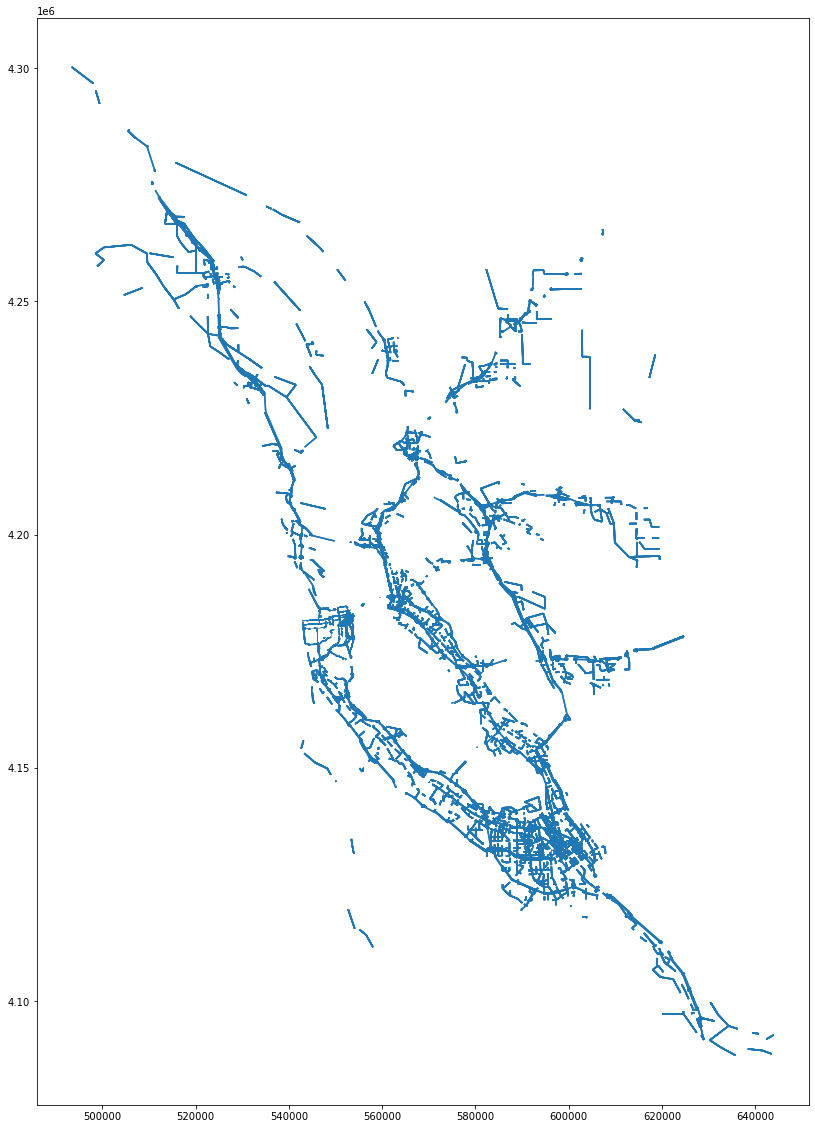

In [89]:
test_join[test_join['FT'].notnull()].plot(figsize=[20,20])